# __Auto Insurance Analysis__

**Author: Matthieu Sattler**

**Sources:** 
* **Training + explanations**: https://www.kaggle.com/c/auto-insurance-fall-2017/data

In this Notebook, we analyze a portfolio of clients for an Insurance comapny. Our goal is to predict if a client is expected to make a claim, kowing some of his characteristics. For clients who are expected to make a claim, we will not try to predict the claim amount. Our dataset consists in approx. 8 000 rows on clients with various features (Sex, Age, Job, area of living, car use...).  


**Summary:**  
The Notebook is structured as follows :  
1 - Import packages and set the environment for data analysis  
2 - Explore, Clean and Preprocess the data  
4 - First results with Machine Learning algorithm  
5 - Fine-tune the algorithm and areas of improvement

___
___


<a id='sec2'></a>
___
## First part : Import Packages + Libraries + Dependencies

In [1]:
# No warnings
import warnings
warnings.filterwarnings('ignore') # Filter out warnings

# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# machine learning
from sklearn.linear_model import LogisticRegression

### Styling and fancy distribution plot

In [2]:
# Plot styling and display options
sns.set(style='white', context='notebook', palette='deep')
plt.rcParams[ 'figure.figsize' ] = 10 , 6
pd.set_option('display.max_columns', 100) # Print 100 Pandas columns

### Load Data

In [3]:
train_df = pd.read_csv('data/train_auto.csv')
test_df = pd.read_csv('data/test_auto.csv')
combine = [train_df, test_df]
# combine is used to ensure whatever preprocessing is done on training data
# is also done on test data

# NOTE! When we change train_df or test_df the objects in combine 
# will also change (combine is only a pointer to the objects)

<a id='sec3'></a>
___
## Explore, Clean and Preprocess the Data

### Data descriptions

> * `TARGET_FLAG` is the feature that we want to predict : for each client, it is equal to 0 if no insurance coverage is claimed and 1 if coverage claimed.  

> * We will explain the other features along the Notebook. Some of them will remain unclear due to a lack of documentation regarding the dataset.  


In [4]:
# Features/Variable names
train_df.columns

Index(['INDEX', 'TARGET_FLAG', 'TARGET_AMT', 'KIDSDRIV', 'AGE', 'HOMEKIDS',
       'YOJ', 'INCOME', 'PARENT1', 'HOME_VAL', 'MSTATUS', 'SEX', 'EDUCATION',
       'JOB', 'TRAVTIME', 'CAR_USE', 'BLUEBOOK', 'TIF', 'CAR_TYPE', 'RED_CAR',
       'OLDCLAIM', 'CLM_FREQ', 'REVOKED', 'MVR_PTS', 'CAR_AGE', 'URBANICITY'],
      dtype='object')

In [5]:
train_df.head()

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,JOB,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,1,0,0.0,0,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,Professional,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
1,2,0,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
2,4,0,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
3,5,0,0.0,0,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,32,Private,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
4,6,0,0.0,0,50.0,0,NaN,"$114,986",No,"$243,925",Yes,z_F,PhD,Doctor,36,Private,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban


In [6]:
# Data Frame information (null, data type etc)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8161 entries, 0 to 8160
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   INDEX        8161 non-null   int64  
 1   TARGET_FLAG  8161 non-null   int64  
 2   TARGET_AMT   8161 non-null   float64
 3   KIDSDRIV     8161 non-null   int64  
 4   AGE          8155 non-null   float64
 5   HOMEKIDS     8161 non-null   int64  
 6   YOJ          7707 non-null   float64
 7   INCOME       7716 non-null   object 
 8   PARENT1      8161 non-null   object 
 9   HOME_VAL     7697 non-null   object 
 10  MSTATUS      8161 non-null   object 
 11  SEX          8161 non-null   object 
 12  EDUCATION    8161 non-null   object 
 13  JOB          7635 non-null   object 
 14  TRAVTIME     8161 non-null   int64  
 15  CAR_USE      8161 non-null   object 
 16  BLUEBOOK     8161 non-null   object 
 17  TIF          8161 non-null   int64  
 18  CAR_TYPE     8161 non-null   object 
 19  RED_CA

___

> #### __Brief Remarks before Data Visualization__

> * `INDEX` is an incremental number and thus does not contain any valuable information. 

> * `INCOME`, `HOME_VAL`, `BLUEBOOK` and `OLDCLAIM` are money amounts, in USD. We need to transform their type from String to Float.

___

#### Drop Index column

In [7]:
# Drop the Index column for the train dataset and the 'TARGET_FLAG' column for the test dataset

train_df = train_df.drop(['INDEX'], axis=1)
test_df = test_df.drop(['TARGET_FLAG'], axis=1)
combine = [train_df, test_df]

#### Parsing

In [8]:
# Parse Money amounts in USD into float types.

columns = ['INCOME', 'HOME_VAL', 'BLUEBOOK', 'OLDCLAIM']

for col in columns :
    for dataset in combine :
        dataset[col] = dataset[col].str.split("\$|,").str.join('').astype('float')

    print('\n new type of '+col+' : ')
    print(train_df[col].dtypes)


 new type of INCOME : 
float64

 new type of HOME_VAL : 
float64

 new type of BLUEBOOK : 
float64

 new type of OLDCLAIM : 
float64


### Data visualization

> **Let's understand our features better.**

#### How much does a claim cost ?

In [9]:
print(train_df['TARGET_FLAG'].describe())
print('\n'+'-'*35+'\n')
print(train_df['TARGET_AMT'].describe(percentiles = [0.6, 0.75, 0.95]))

count    8161.000000
mean        0.263816
std         0.440728
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: TARGET_FLAG, dtype: float64

-----------------------------------

count      8161.000000
mean       1504.324648
std        4704.026930
min           0.000000
50%           0.000000
60%           0.000000
75%        1036.000000
95%        6452.000000
max      107586.136160
Name: TARGET_AMT, dtype: float64


*Remark : we see that only few clients make claims (around 26%) but the standard deviation of those claims is very large. Let's visualize this more clearly.*

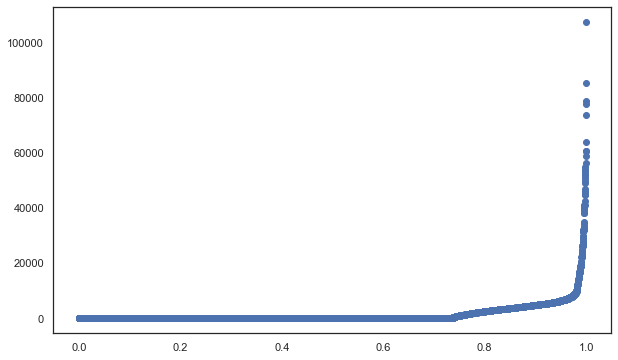

In [10]:
# Plot the quantile function of amounts claimed
sorted_amt = train_df.sort_values(by = ['TARGET_AMT'], ascending = True)['TARGET_AMT']
distribution = train_df.index/8161
plt.scatter(x = distribution, y = sorted_amt)

**Note : The quantile function shows that there is a little share of claims which compose the main share of money claimed. As an insurance company, we will focus on not missing these expensive claims, may it result in a non-negligeable amount of false positives.**

#### Who make the claims ?

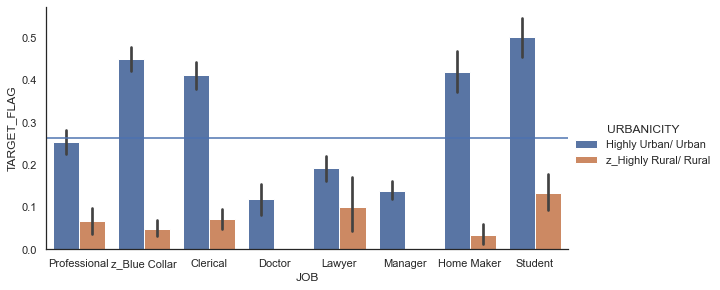

In [11]:
# Plot the proportion of claims relative to Job and Localisation :
sns.catplot(x='JOB', y='TARGET_FLAG', hue = 'URBANICITY', kind="bar", data = train_df, height=4, aspect=2)
ax=plt.gca()
ax.axhline(y=train_df['TARGET_FLAG'].mean())

**Note : The blue line represents the mean proportion of claims (approx. 26%). The graph shows that Students, Blue collars, Home Maker and Clerical living in Urban areas are much more likely to make claims. This is certainly due to `Income` pressure : people making the most claims have low income Jobs and live in more expensive areas.**

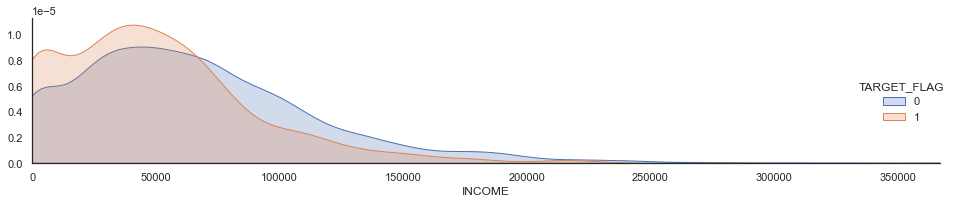

In [12]:
# Plot distribution of Claim relative to Income 

facet = sns.FacetGrid( train_df , hue='TARGET_FLAG' , aspect=4)
facet.map( sns.kdeplot , 'INCOME' , shade= True )
facet.set( xlim=( 0 , train_df['INCOME'].max() ) )
facet.add_legend()
plt.tight_layout()

**Note : This confirms our feeling : people with lower income are more likely to make claim !**

#### Do all those groups make claims of equal amounts ?

*Remark : For the moment, we only focus on "who makes claims ?" without considering the amount of the claims. We would like to make sure that the claim amount is equally distributed between populations : maybe Doctors make very few claims but they are the ones who make all the expensive claims !*

In [13]:
train_df[['JOB', 'TARGET_AMT']].groupby(['JOB'], as_index=True).mean().sort_values(by = 'TARGET_AMT', ascending = False)

,TARGET_AMT
JOB,
z_Blue Collar,2046.224453
Student,1875.703659
Clerical,1589.805162
Professional,1450.614110
Home Maker,1390.230390
Lawyer,1097.693384
Manager,685.499216
Doctor,577.149193


**Note : It is the populations who make the higher number of claims who end up with the higher amount claimed. This means that claim amount is equally distributed between populations : there is not a category of person who make few but expensive claims, on which to focus more particularly.**

#### Does the car have an impact on claim ?

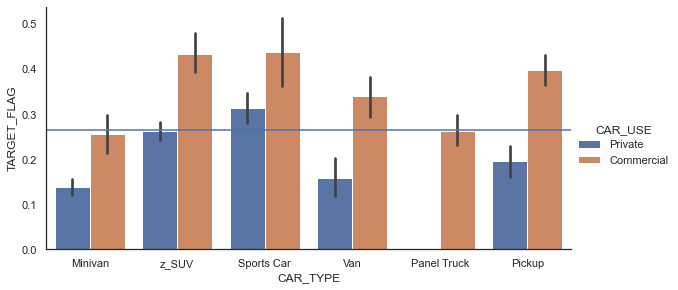

In [14]:
# Plot the proportion of claims relative to Car use and car type :
sns.catplot(x='CAR_TYPE', y='TARGET_FLAG', hue = 'CAR_USE', kind="bar", data = train_df, height=4, aspect=2)
ax=plt.gca()
ax.axhline(y=train_df['TARGET_FLAG'].mean())

**Note : Car usage has a significant impact on probability of making a claim. This is less true for car type. Whatever the car brand, people are more sensitive to the good condition of their car when they use it for visiting their clients !**

#### Does the family situation have an impact on claim ?

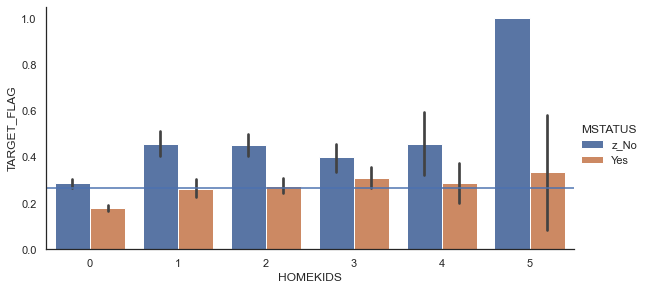

In [15]:
# Plot the proportion of claims relative to Marital status and kids at home :
sns.catplot(x='HOMEKIDS', y='TARGET_FLAG', hue = 'MSTATUS', kind="bar", data = train_df, height=4, aspect=2)
ax=plt.gca()
ax.axhline(y=train_df['TARGET_FLAG'].mean())

**Note : the family situation doesn't seem to impact at all the probability to make a claim. Non married people seem to make a little more claims, but it is also because Students and Clerical are single.**

> * Conclusion : in our model, we will focus on features relative to social status and car usage. They seem to be the most significant features. For keeping our first model easy to interpret, we will drop less significant parameters such as family status.

___
### Data cleaning and preprocessing
___

We will now clean the dataset in order to make it usable. This means that we will :  
> * drop the columns which are not relevant for our model.  
> * manage the rows containing empty values.  

#### Drop secondary or non-interpretable parameters

In [16]:
train_df['KIDSDRIV'].describe()

count    8161.000000
mean        0.171057
std         0.511534
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.000000
Name: KIDSDRIV, dtype: float64

*Remark : `KIDSDRIV` is highly unbalanced : more than 75% of the data is equal to 0. We will therefore drop the column to avoid messing up our prediction.*

**Note : There are many features which both make the model more complicated to interpret and increases risk of overfitting. We will drop two sorts of columns : columns about family-status (`PARENT1`, `MSTATUS`...) which are non significant, as shown before, and the columns with titles that we don't understand (what is `MVR_PTS`?, `YOJ`?).**

In [17]:
# Drop irrelevant columns for the train and test datasets
drop_col = ['TARGET_AMT', 'KIDSDRIV', 'HOMEKIDS', 'YOJ', 'PARENT1', 'MSTATUS', 'BLUEBOOK', 'TIF', 'MVR_PTS']

for col in drop_col :
    train_df = train_df.drop([col], axis=1)
    test_df = test_df.drop([col], axis =1)
    combine = [train_df, test_df]

#### Manage null-values

In [18]:
# Check if there are null values in the datasets

print(train_df.isnull().sum())
print()
print(test_df.isnull().sum())

TARGET_FLAG      0
AGE              6
INCOME         445
HOME_VAL       464
SEX              0
EDUCATION        0
JOB            526
TRAVTIME         0
CAR_USE          0
CAR_TYPE         0
RED_CAR          0
OLDCLAIM         0
CLM_FREQ         0
REVOKED          0
CAR_AGE        510
URBANICITY       0
dtype: int64

INDEX           0
AGE             1
INCOME        125
HOME_VAL      111
SEX             0
EDUCATION       0
JOB           139
TRAVTIME        0
CAR_USE         0
CAR_TYPE        0
RED_CAR         0
OLDCLAIM        0
CLM_FREQ        0
REVOKED         0
CAR_AGE       129
URBANICITY      0
dtype: int64


**Note : There are multiple ways to manage null values :** 
> * We could drop each row containing null values.
> * We could also keep the rows but drop the columns.

We make the assumption that `HOME_VAL` is highly correlated to `INCOME` and `JOB`. We will thus drop this column. For the rest, we drop rows containing null values.  

*Remark : We could also try to fill null values with guessed values. For example we could guess `INCOME` based on the average `INCOME` for a given `JOB`. This is probably what to try in a second step (see Part 5 : areas of improvement).*


In [19]:
# Drop Home_val column, which contains many empty values (8% of the dataset) and we assume correlated to other parameters

train_df = train_df.drop(['HOME_VAL'], axis=1)
test_df = test_df.drop(['HOME_VAL'], axis =1)
combine = [train_df, test_df]

In [20]:
# Drop rows containing na values
train_df.dropna(inplace = True)
test_df.dropna(inplace = True)
combine = [train_df, test_df]

___

#### __Data Preprocessing__

> * `SEX`, `CAR_USE`, `URBANICITY`,  `RED_CAR` and `REVOKED`are binary features that we need to map to integer values.

> * `EDUCATION`, `JOB` and `CAR_TYPE` are categorical features. We will map them to integer values and transform them into dummy variables.

___

In [21]:
# Map binary features into interger values

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
binary = [ 'SEX', 'CAR_USE', 'URBANICITY', 'RED_CAR', 'REVOKED']

for col in binary :
        train_df[col] = le.fit_transform(train_df[col])
        test_df[col] = le.transform(test_df[col])

In [22]:
# Map categorical features into dummy variables

dummy = ['EDUCATION','JOB','CAR_TYPE']

for col in dummy :
    for dataset in combine:
        binary_encoded = pd.get_dummies(dataset[col])
        newcols = binary_encoded.columns
        dataset[newcols] = binary_encoded
        dataset.drop(col, axis=1, inplace=True)

#### Check the result :

In [23]:
train_df.head()

,TARGET_FLAG,AGE,INCOME,SEX,TRAVTIME,CAR_USE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,CAR_AGE,URBANICITY,<High School,Bachelors,Masters,PhD,z_High School,Clerical,Doctor,Home Maker,Lawyer,Manager,Professional,Student,z_Blue Collar,Minivan,Panel Truck,Pickup,Sports Car,Van,z_SUV
0,0,60.0,67349.0,0,14,1,1,4461.0,2,0,18.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,0,43.0,91449.0,0,22,0,1,0.0,0,0,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0
2,0,35.0,16039.0,1,5,1,0,38690.0,2,0,10.0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,50.0,114986.0,1,36,1,0,19217.0,2,1,17.0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
5,1,34.0,125301.0,1,46,0,0,0.0,0,0,7.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


### View the correlation between features in our processed dataset

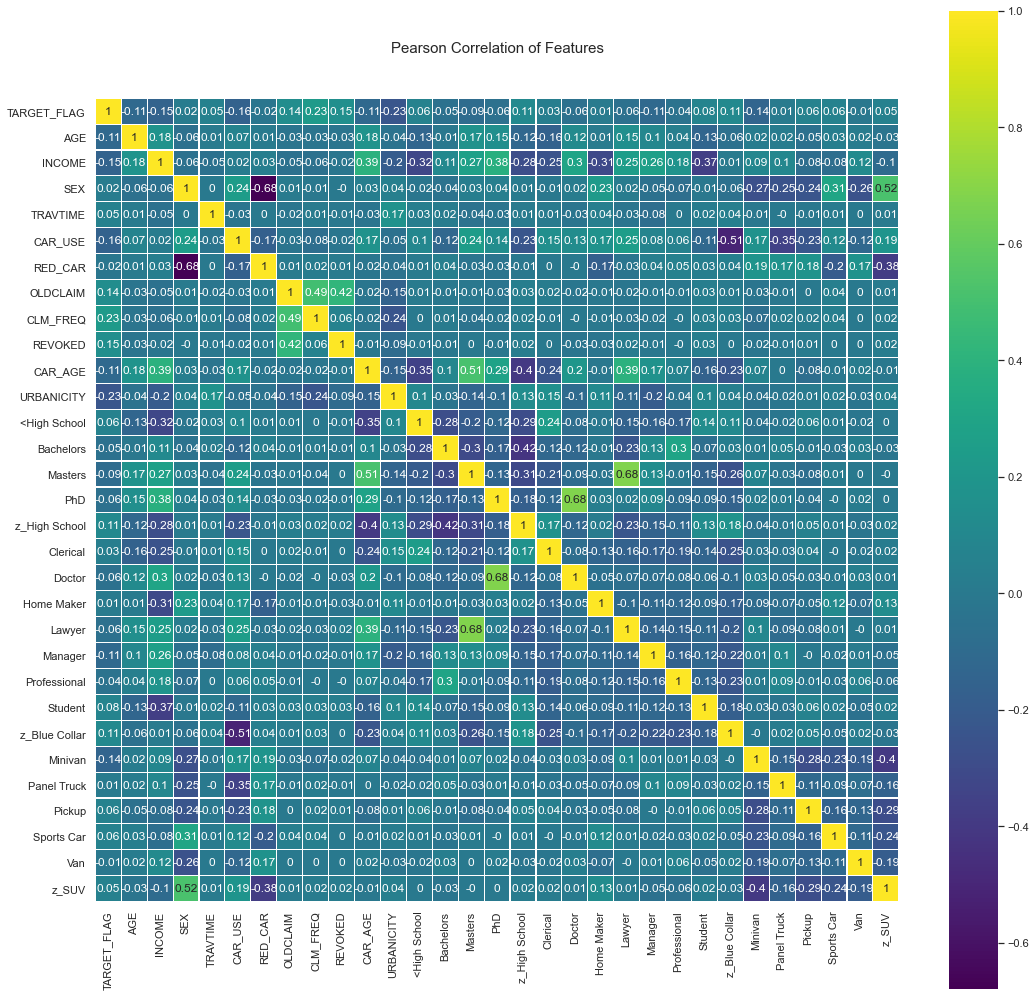

In [24]:
# Uncorrelated features are generally more powerful predictors

colormap = plt.cm.viridis
plt.figure(figsize=(18,18))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_df.corr().round(2)\
            ,linewidths=0.1,vmax=1.0, square=True, cmap=colormap, \
            linecolor='white', annot=True);

*Remark : It might be illegal to predict an insurance price based on Gender. For this reason, we will not use this feature in our predictions. Since Gender is highly correlated to having a red car or a SUV, we assume this will not reduce our model quality too much.*

In [25]:
# Drop the Sex column for the train and test datasets

train_df = train_df.drop(['SEX'], axis=1)
test_df = test_df.drop(['SEX'], axis =1)
combine = [train_df, test_df]

#### Make sure we have a balanced dataset

In [26]:
# Balanced data set?

target_count = train_df['TARGET_FLAG'].value_counts()
target_count

0    4982
1    1786
Name: TARGET_FLAG, dtype: int64

*Remark : the dataset is not very balanced. There are a lot of 0 for few 1. We must be careful with this, because or goal is not to miss the 1, rather than predicting accurately the 0.*

## First results with Machine Learning algorithm

**Note : our problem is a classification problem. Because we are dealing with insurance, we would like our predictions to be easy to explain for our clients. We will therefore chose a Logistic Regression model, which performs well for classification problems and is easy to interpret.**

### Train our model and check the result

In [28]:
X = train_df.drop("TARGET_FLAG", axis=1) # Training & Validation data
Y = train_df["TARGET_FLAG"]              # Response / Target Variable

X_submission  = test_df.drop(['INDEX'], axis=1).copy()

print(X.shape, Y.shape)

(6768, 29) (6768,)


In [29]:
# Split training set so that we validate on 20% of the data
# Note that our algorithms will never have seen the validation data during training.
#This is to evaluate how good our estimators are.

np.random.seed(1337) # set random seed for reproducibility

from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)

print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)

(5414, 29) (5414,)
(1354, 29) (1354,)


In [30]:
logreg = LogisticRegression()                                # instantiate
logreg.fit(X_train, Y_train)                                 # fit
acc_logreg = logreg.score(X_val, Y_val)                  # evaluate

print('Logistic Regression labeling accuracy:', str(round(acc_logreg,2)),'%')

Logistic Regression labeling accuracy: 0.73 %


*Remark : accuracy of the model is rather good, but does this mean that or model is satisfying ?*

### Check False Negative

confusion Matrix
[[970  11]
 [356  17]]


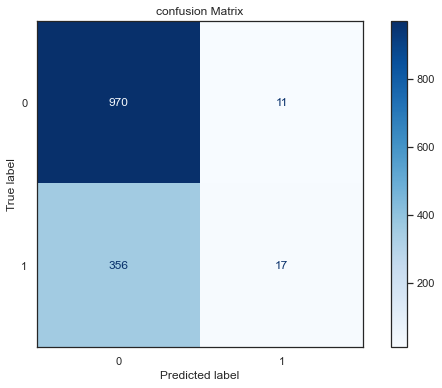

In [31]:
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(logreg, X_val, Y_val,
                            cmap=plt.cm.Blues)
title = 'confusion Matrix'
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

*Let us focus on the recall score : rs = true positive / (true positive + false negative)*

In [32]:
from sklearn.metrics import recall_score
rec_logreg = recall_score(Y_val, logreg.predict(X_val))
print('Logistic Regression labeling recall score:', str(round(rec_logreg,2)),'%')

Logistic Regression labeling recall score: 0.05 %


**Note : Our algortihm makes very poor result. Although 0.73 isn't a bad accuracy score, the level of false negative is very high, resulting in a much higher number of claims for the insurance company than expected, and therefore high unexpected costs. This is why we must focus on the recall score as a metric of interest for improving our model.**

___
## Finetune Machine Learning Algorithm

> * For finetuning the algorithm, we will focus on the recall score, which takes into account false negative and is therefore the true metric of interest for the insurance company.

### Threshold moving

A quick-win for improving our model is to modify the Log Regression Threshold. By reducing the probability Threshold for which we consider that a client will make a claim, we increase the number of predicted claims. This means that we reduce false negative but increase false positive. The ROC Curve can help us define the optimal threshold.

#### Look into ROC

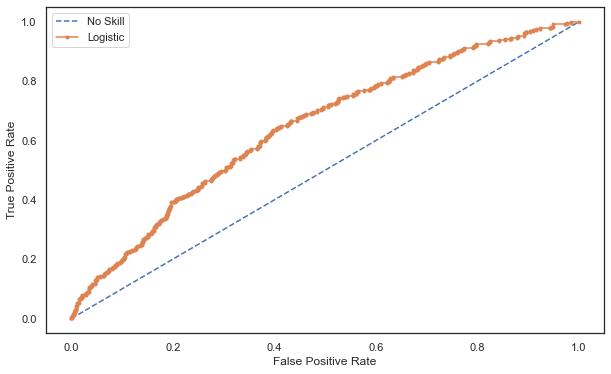

In [33]:
from sklearn.metrics import roc_curve

# predict probabilities
Y_prob = logreg.predict_proba(X_val)

# keep probabilities for the positive outcome only
Y_prob = Y_prob[:, 1]

# calculate roc curves
fpr, tpr, thresholds = roc_curve(Y_val, Y_prob)

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

**Note : The ROC curve shows an inflexion for a threshold to 0.2. We will therefore change it to this value.**

#### Move Threshold

In [34]:
# Compute new prediction with a lower threshold

mythreshold = 0.2
Y_new_pred = (Y_prob >= mythreshold).astype(int)
rec_logreg = recall_score(Y_val, Y_new_pred)
print('Logistic Regression labeling recall score:', str(round(rec_logreg,2)),'%')

Logistic Regression labeling recall score: 0.86 %


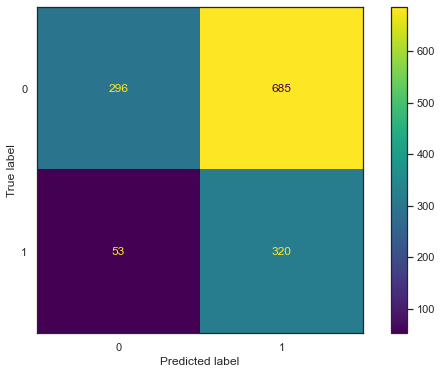

In [35]:
# display confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 
cm = confusion_matrix(Y_val, Y_new_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot() 

**Note : We now have a much better prediction of claims : we have more true positives, less false negative. This is good for the insurance company who will not have many bad surprises. Our problem now is that we have a lot of false positive. This will result in higher prices for the clients. This is a less serious problem than false negative, but we have to deal with it in order to have a satisfying model.**

*Remark : Our goal now is to increase accuracy while maintaining recall score at a high level.*

In [36]:
# Compute new accuracy
acc_logreg_new = sum(Y_new_pred == Y_val)/len(Y_val)*100
print('Logistic Regression labeling accuracy:', str(round(acc_logreg_new,2)),'%')

Logistic Regression labeling accuracy: 45.49 %


**Some Hints for increasing the algorithm performance :**  
> * Better choosing the features for the model (which columns do we keep, which columns do we drop ?)  
> * Better filling the empty values of the database rather than droping all rows containing null values.  
> * Trying other classification models.  
> * Finetuning model parameters.  

## Prediction on the test set

In [38]:
logreg.fit(X, Y)  
# predict probabilities
Y_prob_sub = logreg.predict_proba(X_submission)

# keep probabilities for the positive outcome only
Y_prob_sub = Y_prob_sub[:, 1]

Y_submission = (Y_prob_sub >= mythreshold).astype(int)

submission = pd.DataFrame({
        "INDEX": test_df["INDEX"],
        "TARGET_FLAG": Y_submission
    })
submission.to_csv('auto_insurance.csv', index=False)